# Modelling & Evaluation Notebook 

## Objectives
- Fit and evaluate a classification model to predict house prices.

## Inputs
- outputs/datasets/collection/HousePrices.csv
- Instructions on whch variables to use for data cleaning and feature engineering. These are found in each respective notebook

## Outputs
- Train set
- Test set
- Data cleaning and feature engineering pipeline
- Modeling pipeline
- Feature importance plot

---

## Change working directory
Change current working directory to its parent

In [1]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")

You set a new current working directory


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# dropping ['WoodDeckSF', 'EnclosedPorch'] as discussed in 02DataCleaning
df = (pd.read_csv("outputs/datasets/collection/HousingPrices.csv").drop(labels=['WoodDeckSF', 'EnclosedPorch'], axis=1))

print(df.shape)
df.head()

(1460, 28)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1717,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2198,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Step 2: ML Pipeline

### ML Pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.base import BaseEstimator, TransformerMixin


# data cleaning
def get_cleaning_pipeline():
    cleaning_pipeline = Pipeline([
        ( 'median',  MeanMedianImputer(imputation_method='median',
                                        variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea']) ),
        ( 'zero_variables',  ArbitraryNumberImputer(arbitrary_number=-0,
                                                    variables=['2ndFlrSF', 'GarageAge']) ),
        ( 'cat_imputer',  CategoricalImputer(imputation_method='missing',
                                            variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure']) )
    ])

    return cleaning_pipeline

# feature engineering
# ordinal encoding
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_KitchenQual = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1}
        self.mapping_BsmtExposure = {'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'Missing':1}
        self.mapping_BsmtFinType1 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'Missing':1}
        self.mapping_GarageFinish = {'Fin':4, 'RFn':3, 'Unf':2, 'Missing':1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['KitchenQual_enc'] = X['KitchenQual'].map(self.mapping_KitchenQual)
        X['BsmtExposure_enc'] = X['BsmtExposure'].map(self.mapping_BsmtExposure)
        X['BsmtFinType1_enc'] = X['BsmtFinType1'].map(self.mapping_BsmtFinType1)
        X['GarageFinish_enc'] = X['GarageFinish'].map(self.mapping_GarageFinish)
        X.drop(columns=['KitchenQual', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish'], inplace=True)
        return X

# numerical pipeline
def get_numerical_pipeline():
    winsor_vars = ['GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'AboveGradeSF']
    log_vars = ['1stFlrSF', 'GrLivArea', 'AboveGradeSF']
    power_vars = ['TotalSF']

    numerical_pipeline = Pipeline([
        ('winsorizer',  Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsor_vars)),
        ('log_transformer', LogTransformer(variables=log_vars)),
        ('power_transformer', PowerTransformer(variables=power_vars)),
        ('discretiser', EqualWidthDiscretiser(bins=5, variables=winsor_vars))
    ])

    return numerical_pipeline


def PipelineDataCleaningAndFeatureEngineering():
    cleaning_pipeline = get_cleaning_pipeline()
    ordinal_encoder = OrdinalEncoder()
    numerical_pipeline = get_numerical_pipeline()
    
    pipeline_base = Pipeline([
        ('cleaning', cleaning_pipeline),
        ('ordinal_encoder', ordinal_encoder),
        ('numerical_pipeline', numerical_pipeline)
    ])

    return pipeline_base

      

### ML Pipeline for Modelling and Hyperparameter Optimisation

#### Modelling

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

#### Hyperparamater optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


## Grid Search CV - Sklearn

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


models_quick_search = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=0),
    'Ridge': Ridge(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'ElasticNet': {},
    'Ridge': {},
    'Lasso': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Hyperparameter optimisation search using default hyperparameters

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ElasticNet 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Ridge 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages

Check Results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,ElasticNet,0.723714,0.805087,0.847722,0.047412
5,GradientBoostingRegressor,0.60966,0.774369,0.849671,0.084834
2,Ridge,0.688617,0.774171,0.808233,0.044081
0,LinearRegression,0.685435,0.768098,0.808318,0.042574
4,RandomForestRegressor,0.617971,0.742544,0.802188,0.06549
6,XGBRegressor,0.543707,0.73283,0.824866,0.097661
3,DecisionTreeRegressor,0.425758,0.59792,0.711623,0.103804


Observations:
- ElasticNet seems to perform the best
- Other models have min_score below the 0.7 R2 threshold set with client

## Extensive search on most suitable model

Define model and parameters

In [13]:
models_search = {
    "ElasticNet": ElasticNet(random_state=0)
}

params_search = {
    'ElasticNet': {
        'model__alpha': np.logspace(-4, 1, 10), 
        'model__l1_ratio': np.linspace(0, 1, 11) 
    }
}

Extensive GridSearch CV

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ElasticNet 

Fitting 5 folds for each of 110 candidates, totalling 550 fits


/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.017e+11, tolerance: 5.798e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.986e+11, tolerance: 5.678e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the 

Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__alpha,model__l1_ratio
25,ElasticNet,0.724813,0.823646,0.865272,0.051144,0.001292,0.3
41,ElasticNet,0.724865,0.823646,0.865271,0.051124,0.004642,0.8
26,ElasticNet,0.72452,0.823644,0.865273,0.051249,0.001292,0.4
24,ElasticNet,0.725085,0.823642,0.865266,0.051044,0.001292,0.2
27,ElasticNet,0.724204,0.823636,0.865269,0.051362,0.001292,0.5
...,...,...,...,...,...,...,...
103,ElasticNet,0.513851,0.569383,0.610176,0.035973,10.0,0.4
102,ElasticNet,0.483199,0.5354,0.573586,0.033717,10.0,0.3
101,ElasticNet,0.455577,0.504746,0.540351,0.031625,10.0,0.2
100,ElasticNet,0.430661,0.477064,0.510179,0.029696,10.0,0.1


Check best model

In [16]:
best_model = grid_search_summary.iloc[0, 0]
grid_search_pipelines[best_model].best_params_

{'model__alpha': 0.001291549665014884, 'model__l1_ratio': 0.30000000000000004}

Define best regressor, based on search

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ElasticNet(random_state=0))),
                ('model',
                 ElasticNet(alpha=0.001291549665014884,
                            l1_ratio=0.30000000000000004, random_state=0))])

## Assessing Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['TotalSF', '2ndFlrSF', 'TotalBsmtSF', '1stFlrSF', 'OverallQual', 'KitchenQual_enc', 'BsmtFinSF1', 'LotArea', 'GarageArea', 'HouseAge', 'MasVnrArea', 'GrLivArea']


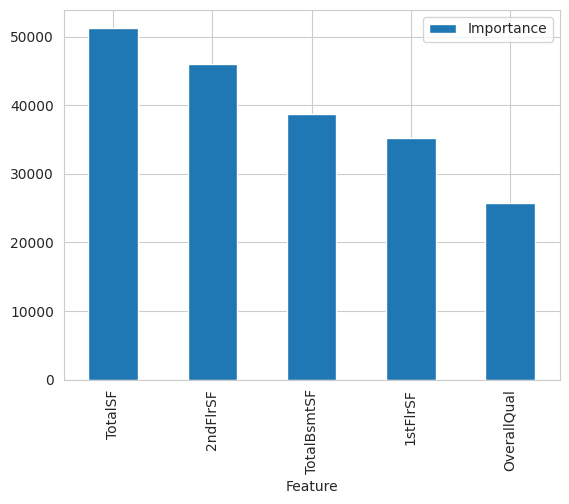

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2

# partial pipeline up to feature engineering
pipeline_up_to_feat_eng = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
X_train_cleaned = pipeline_up_to_feat_eng.transform(X_train)

# column name after pre-processing
if isinstance(X_train_cleaned, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_train_cleaned.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns

# features selected
support_mask = best_regressor_pipeline['feat_selection'].get_support()
best_features = columns_after_data_cleaning_feat_eng[support_mask].to_list()

# coefficients from final lasso model
coefs = best_regressor_pipeline['model'].coef_

# create dataframe
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Coefficient': coefs
}).assign(Importance=lambda df: np.abs(df['Coefficient'])).sort_values(by='Importance', ascending=False)

# absolute importance
df_feature_importance['Importance'] = df_feature_importance['Coefficient'].abs()

# filter by threshold
threshold = 0.3 * df_feature_importance['Importance'].max()

important_df = df_feature_importance[df_feature_importance['Importance'] >= threshold]
important_df = important_df.sort_values(by='Importance', ascending=False)

print(f"* These are the {important_df.shape[0]} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

important_df.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.832
Mean Absolute Error: 21146.834
Mean Squared Error: 1031498778.411
Root Mean Squared Error: 32116.955


* Test Set
R2 Score: 0.655
Mean Absolute Error: 24881.343
Mean Squared Error: 2382181831.765
Root Mean Squared Error: 48807.6




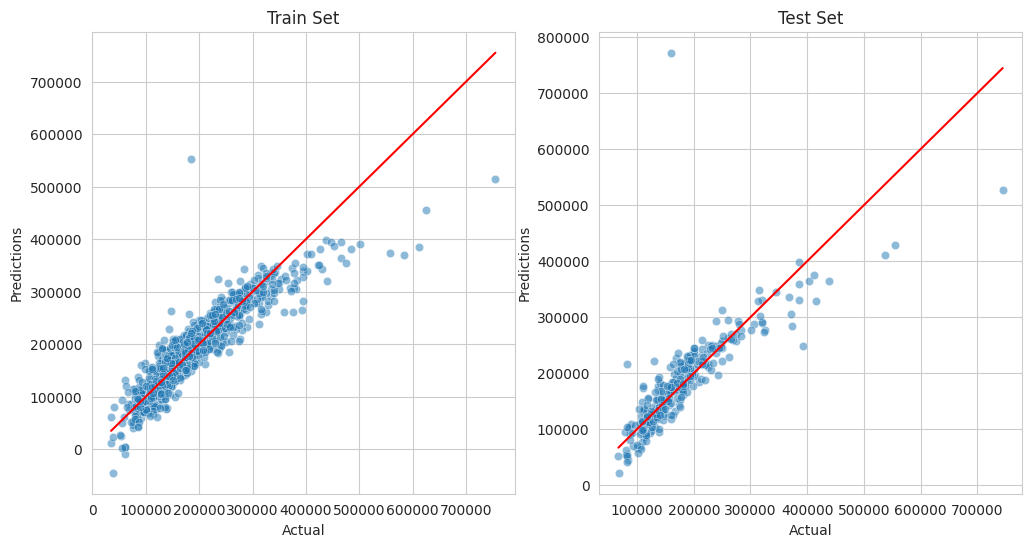

In [20]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Observations:
- R2 for Test Set is below the 0.7 threshold set with client
- Predictions for higher sale prices are much lower than the actuals. This is likely due to skewness of SalePrice

## Handling Target imbalance

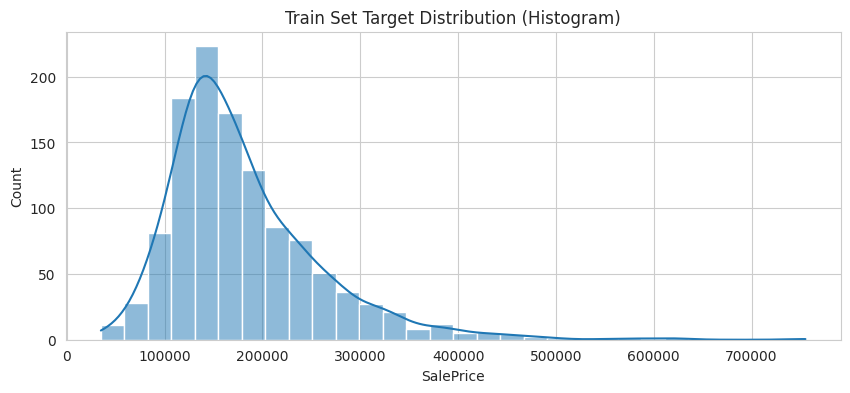

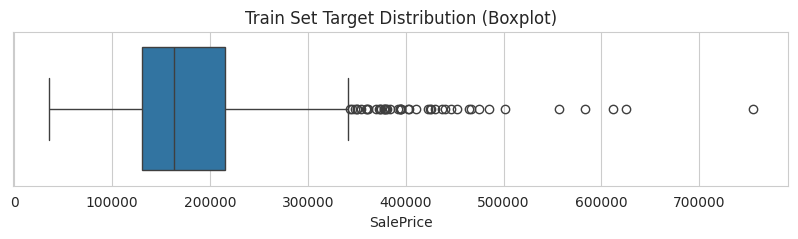

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Train Set Target Distribution (Histogram)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=y_train)
plt.title("Train Set Target Distribution (Boxplot)")
plt.xlabel("SalePrice")
plt.show()

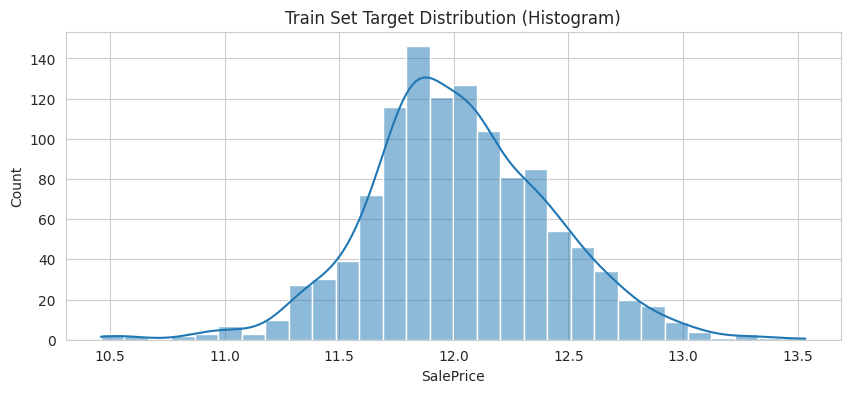

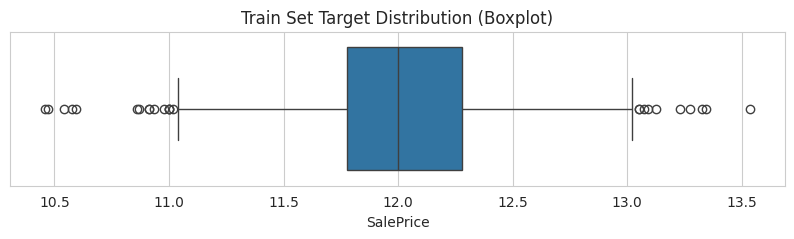

In [22]:
import numpy as np

y_train = np.log(y_train)
y_test = np.log(y_test)

import seaborn as sns
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Train Set Target Distribution (Histogram)")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=y_train)
plt.title("Train Set Target Distribution (Boxplot)")
plt.xlabel("SalePrice")
plt.show()

### Split Train and Test Set

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


In [24]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [25]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


## Grid Search CV - Sklearn

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


models_quick_search = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=0),
    'Ridge': Ridge(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'ElasticNet': {},
    'Ridge': {},
    'Lasso': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Hyperparameter optimisation search using default hyperparameters

In [27]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ElasticNet 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for Ridge 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/codespace/.python/current/lib/python3.12/site-packages

Check Results

In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,Ridge,0.810693,0.865412,0.897545,0.031734
0,LinearRegression,0.810297,0.865364,0.897642,0.031894
5,GradientBoostingRegressor,0.728807,0.798964,0.848408,0.040985
6,XGBRegressor,0.740816,0.794685,0.828566,0.0328
4,RandomForestRegressor,0.697962,0.758146,0.853135,0.052973
3,DecisionTreeRegressor,0.618418,0.650013,0.684023,0.024744
1,ElasticNet,-0.01848,-0.004796,-0.000017,0.006958


Observations:
- Ridge and LinearRegression are best performing with default hyperparameters - highest mean R2 score and relatively low std dev
- ElasticNet, interestingly, performs the worst after log trasnform of SalePrice
- GradientBoosting is a strong runner up 

## Extensive search on most suitable model

Define model and parameters

In [29]:
models_search = {
    "Ridge": Ridge(random_state=0),
}

params_search = {
    "Ridge": {
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 200, 500, 1000],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'model__tol': [1e-4, 1e-3, 1e-2],
        'model__max_iter': [1000, 5000, 10000],
    }
}

Extensive GridSearch CV

In [30]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for Ridge 

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


Check results

In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__alpha,model__max_iter,model__solver,model__tol
221,Ridge,0.810702,0.865858,0.897328,0.031945,1,5000,lsqr,0.01
200,Ridge,0.810702,0.865858,0.897328,0.031945,1,1000,lsqr,0.01
242,Ridge,0.810702,0.865858,0.897328,0.031945,1,10000,lsqr,0.01
179,Ridge,0.810464,0.86585,0.897412,0.032053,0.1,10000,lsqr,0.01
137,Ridge,0.810464,0.86585,0.897412,0.032053,0.1,1000,lsqr,0.01
...,...,...,...,...,...,...,...,...,...
515,Ridge,0.751619,0.794475,0.825519,0.025819,1000,1000,lsqr,0.01
557,Ridge,0.751619,0.794475,0.825519,0.025819,1000,10000,lsqr,0.01
536,Ridge,0.751619,0.794475,0.825519,0.025819,1000,5000,lsqr,0.01
560,Ridge,0.751619,0.794475,0.825519,0.025819,1000,10000,sparse_cg,0.01


Check best model

In [32]:
best_model = grid_search_summary.iloc[0, 0]
grid_search_pipelines[best_model].best_params_

{'model__alpha': 1,
 'model__max_iter': 1000,
 'model__solver': 'lsqr',
 'model__tol': 0.01}

Define best regressor, based on search

In [33]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=Ridge(random_state=0))),
                ('model',
                 Ridge(alpha=1, max_iter=1000, random_state=0, solver='lsqr',
                       tol=0.01))])

## Assessing Feature Importance

* These are the 9 most important features in descending order. The model was trained on them: 
['HouseAge', 'OverallQual', 'TotalSF', 'GrLivArea', 'AboveGradeSF', 'OverallCond', '1stFlrSF', 'LotArea', '2ndFlrSF']


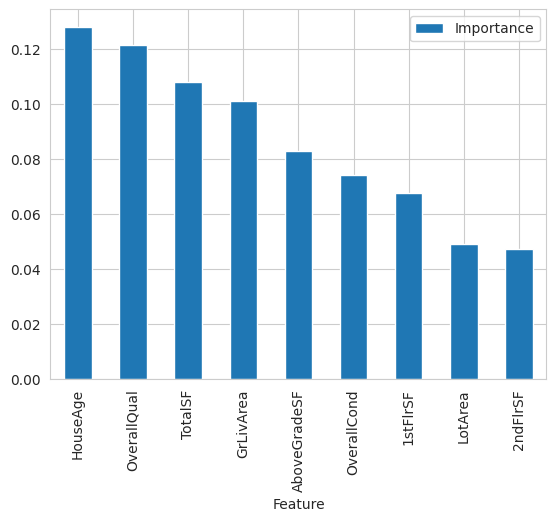

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2

# partial pipeline up to feature engineering
pipeline_up_to_feat_eng = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
X_train_cleaned = pipeline_up_to_feat_eng.transform(X_train)

# column name after pre-processing
if isinstance(X_train_cleaned, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_train_cleaned.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns

# features selected
support_mask = best_regressor_pipeline['feat_selection'].get_support()
best_features = columns_after_data_cleaning_feat_eng[support_mask].to_list()

# coefficients from final lasso model
coefs = best_regressor_pipeline['model'].coef_

# create dataframe
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Coefficient': coefs
}).assign(Importance=lambda df: np.abs(df['Coefficient'])).sort_values(by='Importance', ascending=False)

# absolute importance
df_feature_importance['Importance'] = df_feature_importance['Coefficient'].abs()

# filter by threshold
threshold = 0.3 * df_feature_importance['Importance'].max()

important_df = df_feature_importance[df_feature_importance['Importance'] >= threshold]
important_df = important_df.sort_values(by='Importance', ascending=False)

print(f"* These are the {important_df.shape[0]} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

important_df.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.871
Mean Absolute Error: 0.103
Mean Squared Error: 0.021
Root Mean Squared Error: 0.144


* Test Set
R2 Score: 0.794
Mean Absolute Error: 0.109
Mean Squared Error: 0.031
Root Mean Squared Error: 0.177




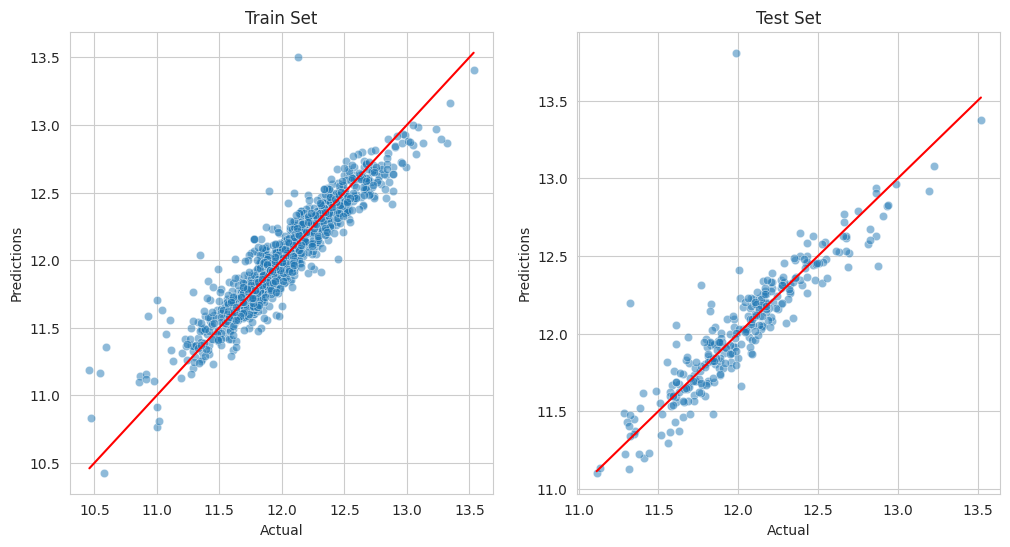

In [35]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Interpreting MAE, MSE, and RMSE

In [36]:
import numpy as np
# since used y = log(saleprice)
# original sale price = e^y
mae = np.exp(0.109)
mse = np.exp(0.031)
rmse = np.exp(0.177)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)

MAE:  1.1151623503414478
MSE:  1.0314855038865227
RMSE:  1.1936310931271388


Observations:
- Since using log transform on the SalePrice, the Ridge model with these hyperparameters performs well
- R2 on unseen data (0.794) is quite good - model generalises well, and drop from train to test isn't too large, so overfitting isn't an issue
- MAE ~0.1 (log scale) -> ~10.5% average absolute error in price
- RMSE ~0.18 (log scale) -> 19.7% typical error magnitdue in price

## Checking Linear Regression Model to compare

In [37]:
models_search = {
    "LinearRegression": LinearRegression(),
}

params_search = {
    'LinearRegression': {}
}

Extensive GridSearch CV

In [38]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [39]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.810297,0.865364,0.897642,0.031894


Check best model

In [40]:
best_model = grid_search_summary.iloc[0, 0]
grid_search_pipelines[best_model].best_params_

{}

Define best regressor, based on search

In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

## Assessing Feature Importance

* These are the 9 most important features in descending order. The model was trained on them: 
['OverallQual', 'HouseAge', 'TotalSF', 'GrLivArea', 'AboveGradeSF', 'OverallCond', '1stFlrSF', 'LotArea', '2ndFlrSF']


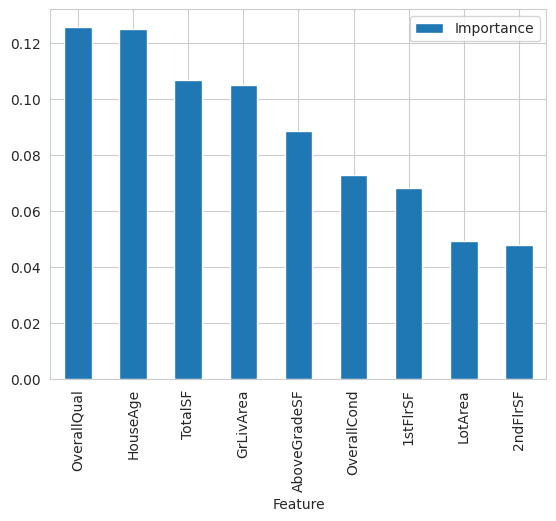

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2

# partial pipeline up to feature engineering
pipeline_up_to_feat_eng = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
X_train_cleaned = pipeline_up_to_feat_eng.transform(X_train)

# column name after pre-processing
if isinstance(X_train_cleaned, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_train_cleaned.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns

# features selected
support_mask = best_regressor_pipeline['feat_selection'].get_support()
best_features = columns_after_data_cleaning_feat_eng[support_mask].to_list()

# coefficients from final lasso model
coefs = best_regressor_pipeline['model'].coef_

# create dataframe
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Coefficient': coefs
}).assign(Importance=lambda df: np.abs(df['Coefficient'])).sort_values(by='Importance', ascending=False)

# absolute importance
df_feature_importance['Importance'] = df_feature_importance['Coefficient'].abs()

# filter by threshold
threshold = 0.3 * df_feature_importance['Importance'].max()

important_df = df_feature_importance[df_feature_importance['Importance'] >= threshold]
important_df = important_df.sort_values(by='Importance', ascending=False)

print(f"* These are the {important_df.shape[0]} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

important_df.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.871
Mean Absolute Error: 0.103
Mean Squared Error: 0.021
Root Mean Squared Error: 0.144


* Test Set
R2 Score: 0.794
Mean Absolute Error: 0.109
Mean Squared Error: 0.031
Root Mean Squared Error: 0.177




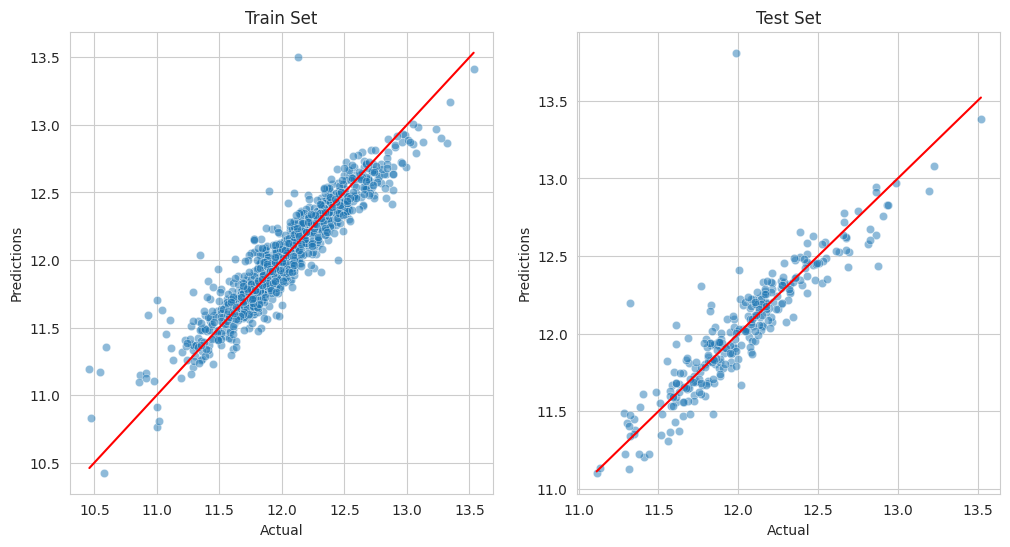

In [43]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Comparison to Ridge:
- both models work well - Ridge regularisaion isn't giving much gain with this dataset
- LinearRegression could be used for simplicity
- Ridge could be used for insurance against overfitting if we want to add features later on  

---

## Refitting pipeline with best features

In [44]:
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        #("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [45]:
print(best_features)

['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'OverallCond', 'OverallQual', 'HouseAge', 'TotalSF', 'AboveGradeSF']


best_features are the same for both LinearRegression and Ridge so keeping this variable the same

Splitting train test set with best features only

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


In [47]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
X_train.to_csv('outputs/ml_pipeline/predict_sale_price/v1/X_train_raw.csv', index=False)
X_test.to_csv('outputs/ml_pipeline/predict_sale_price/v1/X_test_raw.csv', index=False)

In [49]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 27) (1168,) (292, 27) (292,)


/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

Grid Search CV - Sklearn
- Best model and parameters

In [ ]:
models_search = {
    "Ridge": Ridge(random_state=0),
}

params_search = {
    "Ridge": {
        'model__alpha': [1],
        'model__solver': ['lsqr'],
        'model__tol': [0.01],
        'model__max_iter': [1000],
    }
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

In [ ]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

In [ ]:
data_cleaning_feat_eng_steps = 1

pipeline_up_to_feat_eng = Pipeline(pipeline_reg.steps[:data_cleaning_feat_eng_steps])
X_transformed = pipeline_up_to_feat_eng.transform(X_train)

if isinstance(X_transformed, pd.DataFrame):
    columns_after_data_cleaning_feat_eng = X_transformed.columns
else:
    columns_after_data_cleaning_feat_eng = X_train.columns

if hasattr(pipeline_reg['model'], "feature_importances_"):
    importances = pipeline_reg['model'].feature_importances_
elif hasattr(pipeline_reg['model'], "coef_"):
    importances = np.abs(pipeline_reg['model'].coef_)
else:
    raise ValueError("Model does not have feature_importances_ or coef_")

df_feature_importance = pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(f"* These are the {len(columns_after_data_cleaning_feat_eng)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance', figsize=(12, 6))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_reg)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_reg)

## Push files to repo

We will generate the following
- train set
- test set
- modelling pipeline
- label map
- feature importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Train Set

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train_original = np.exp(y_train)
y_train_original

In [ ]:
y_train_original.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test_original = np.exp(y_test)
y_test_original.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling pipeline

In [ ]:
pipeline_reg

In [ ]:
joblib.dump(value=pipeline_reg, filename=f"{file_path}/reg_pipeline.pkl")

### Label mappings

In [ ]:
mappings = {
    "KitchenQual": {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1},
    "BsmtExposure": {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'Missing': 1},
    "BsmtFinType1": {'GLQ': 7, 'ALQ': 6, 'BLQ': 5, 'Rec': 4, 'LwQ': 3, 'Unf': 2, 'Missing': 1},
    "GarageFinish": {'Fin': 4, 'RFn': 3, 'Unf': 2, 'Missing': 1}
}

In [ ]:
joblib.dump(value=mappings, filename=f"{file_path}/mappings.pkl")

### Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')